In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('~/shared/problem2.csv', sep=';')
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


## EDA

In [3]:
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt

In [4]:
duplicateRows = df.loc[df.duplicated()]
duplicateRows

,user_id,revenue,testgroup


In [5]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [6]:
df.loc[df["revenue"] > 0, "paid"] = True
df["paid"] = df["paid"].fillna(False)

In [7]:
df

,user_id,revenue,testgroup,paid
0,1,0,b,False
1,2,0,a,False
2,3,0,a,False
3,4,0,b,False
4,5,0,b,False
...,...,...,...,...
404765,404766,0,a,False
404766,404767,0,b,False
404767,404768,231,a,True
404768,404769,0,a,False


In [8]:
df_agg = df.copy()
df_agg = df_agg.groupby('testgroup').agg({'user_id': 'count', 'paid': 'sum', 'revenue': 'sum'})
df_agg.columns = ['users', 'payers', 'revenue']
df_agg["CR,%"] = round((df_agg["payers"] / df_agg["users"]).mul(100), 2)
df_agg['ARPU'] = round(df_agg["revenue"] / df_agg["users"], 2)
df_agg['ARPPU'] = round(df_agg["revenue"] / df_agg["payers"], 2)

In [9]:
df_agg

,users,payers,revenue,"CR,%",ARPU,ARPPU
testgroup,,,,,,
a,202103,1928,5136189,0.95,25.41,2664.00
b,202667,1805,5421603,0.89,26.75,3003.66


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

Из этого выяснили, что А - контрольная, Б - тестовая

In [11]:
A = df[df['testgroup']== 'a']
A

,user_id,revenue,testgroup,paid
1,2,0,a,False
2,3,0,a,False
9,10,0,a,False
10,11,0,a,False
11,12,0,a,False
...,...,...,...,...
404760,404761,0,a,False
404762,404763,0,a,False
404765,404766,0,a,False
404767,404768,231,a,True


In [12]:
A[A['revenue'] > 0].revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

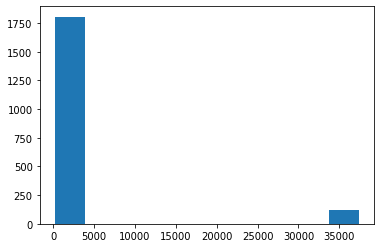

In [13]:
plt.hist(A[A['revenue'] > 0].revenue)
plt.show()

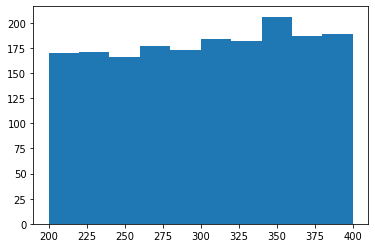

In [14]:
plt.hist(A[(A['revenue'] > 0) & (A['revenue'] < 5000)].revenue)
plt.show()

In [15]:
B = df[df['testgroup']== 'b']
B

,user_id,revenue,testgroup,paid
0,1,0,b,False
3,4,0,b,False
4,5,0,b,False
5,6,0,b,False
6,7,0,b,False
...,...,...,...,...
404761,404762,0,b,False
404763,404764,0,b,False
404764,404765,0,b,False
404766,404767,0,b,False


In [16]:
B[B['revenue'] > 0].revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

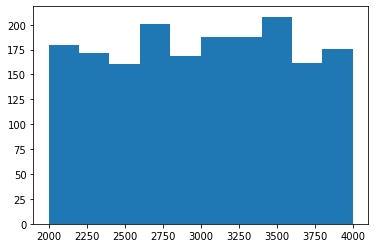

In [17]:
plt.hist(B[B['revenue'] > 0].revenue)
plt.show()

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


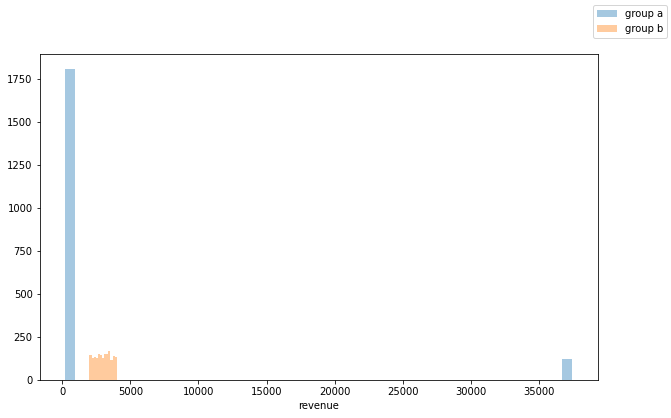

In [18]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df[df['revenue'] > 0].query('testgroup == "a"').revenue, kde=False)
sns.distplot(df[df['revenue'] > 0].query('testgroup == "b"').revenue, kde=False)
fig.legend(labels=['group a','group b'])
plt.show()

## Гипотезы


### Нормальность данных

- H0: распределение не отличается от нормального
- H1: распределение отличается от нормального

In [19]:
from scipy import stats
from scipy.stats import normaltest

print(normaltest(df[df.testgroup == 'a'].revenue))
print(normaltest(df[df.testgroup == 'b'].revenue))

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)
NormaltestResult(statistic=326622.39540856465, pvalue=0.0)


##### Вывод про нормальность данных

Отвергаю Н0, распределение данных в двух группа отличается от нормального, pvalue < 0.05.

### Гомогенность дисперсии

- H0: дисперсии внутри групп гомогенны
- H1: дисперсии внутри групп не гомогенны

In [20]:
from scipy.stats import levene

_, pv = levene(A.revenue, B.revenue)
pv

0.5324948591043842

##### Вывод про гомогенность дисперсии

Принимаю H0, дисперсии внутри групп гомогенны, pvalue > 0.05.

In [21]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm.auto import tqdm 

def bootstrap(
    data_1, 
    data_2,
    statistic = np.mean,
    confidence_level = 0.95 
):
    """
    get_bootstrap - returns p_value

    statistic: callable    Statistic for which the confidence interval is to be calculated. 
    confidence_level       The confidence level of the confidence interval.
    """

    boot_data = []
    for i in tqdm(range(1000)):
        samples_1 = data_1.sample(len(data_1), replace = True).values
        samples_2 = data_2.sample(len(data_2), replace = True).values
        boot_data.append(statistic(samples_1) - statistic(samples_2))

    df = pd.DataFrame(boot_data)

    left_quant = (1 - confidence_level) / 2
    right_quant = 1 - (1 - confidence_level) / 2
    quants = df.quantile([left_quant, right_quant])

    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))

    p_value = min(p_1, p_2) * 2

    return {"data": df, "quants": quants, "p_value": p_value}

def plot_bootstrap(res):
    _, _, bars = plt.hist(res["data"][0], bins = 50)
    for bar in bars:
        if bar.get_x() <= res["quants"].iloc[0][0] or bar.get_x() >= res["quants"].iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(res["quants"], ymin=0, ymax=50, linestyle='--')
    plt.ylabel('frequency')
    plt.show()

### Является ли увеличение ARPU на 5% статистически значимыми?

- H0: c высокой долей вероятности различия не имеют статистической значимости
- H1: c высокой долей вероятности различия cтатистически значимы

In [39]:
from scipy.stats import ttest_ind

_, pv = ttest_ind(A["revenue"], B["revenue"])
pv

0.532494858971837

##### Вывод:

Принимаю H0 c высокой долей вероятностиразличия не имеют статистической значимости, pvalue > 0.05.

In [35]:
from scipy.stats import mannwhitneyu

_, pv = mannwhitneyu(A["revenue"], B["revenue"])
pv

0.06269701316074398

##### Вывод:

Принимаю H0, c высокой долей вероятности различия не имеют статистической значимости, pvalue < 0.05.

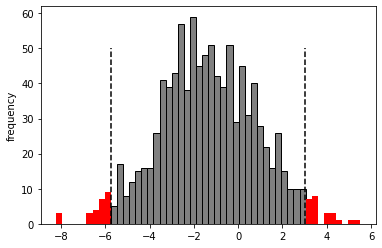

0.5417606443826191

In [22]:
res = bootstrap(A["revenue"], B["revenue"])
plot_bootstrap(res)

res["p_value"]

##### Вывод:

Принимаю H0, c высокой долей вероятности различия не имеют статистической значимости, pvalue > 0.05.

###  Является ли увеличение ARPPU в тестовой группе на 13% статистически значимыми?

- H0: c высокой долей вероятности различия не имеют статистической значимости
- H1: c высокой долей вероятности различия cтатистически значимы

In [43]:
from scipy.stats import ttest_ind

_, pv = ttest_ind(A[A["revenue"] > 0]["revenue"], B[B["revenue"] > 0]["revenue"])
pv

0.11153459157259504

##### Вывод:

Принимаю H0, c высокой долей вероятности различия не имеют статистической значимости, pvalue > 0.05.

In [33]:
from scipy.stats import mannwhitneyu

_, pv = mannwhitneyu(A[A["revenue"] > 0]["revenue"], B[B["revenue"] > 0]["revenue"])
pv

0.0

##### Вывод:

Принимаю H0, c высокой долей вероятности различия не имеют статистической значимости, pvalue < 0.05.

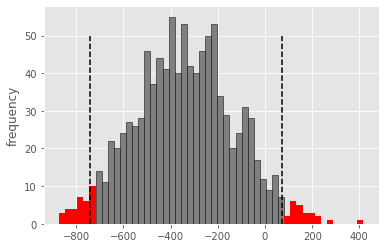

0.10807584796445635

In [37]:
res = bootstrap(A[A["revenue"] > 0]["revenue"], B[B["revenue"] > 0]["revenue"])
plot_bootstrap(res)

res["p_value"]

##### Вывод:

Принимаю H0, c высокой долей вероятности различия не имеют статистической значимости, pvalue > 0.05.

###  Является ли уменьшением CR,% в тестовой группе на 6,74% статистически значимым?

- H0: факт оплаты не зависит от группы
- H1: факт оплаты зависит от группы

In [27]:
from scipy.stats import chi2_contingency

_, pv, _, _ = chi2_contingency(pd.crosstab(df["paid"], df["testgroup"]))
pv

0.03647561892312613

##### Вывод:

Отклоняю H0, факт оплаты зависит от группы, pvalue < 0.05.

## Итоги:

## А- контрольная группа, B - тестовая. Были подсчитаны метрики: ARPU, ARPPU и CR(конверсия в покупку). По результатам статистического анализа нет оснований утверждать, что увеличение ARPU и ARPPU в тестовой группе статистически значимо. В то же время, уменьшение конверсии именно в тестовой группе статистически подтвердилось. Это означает, что по имеющимся данным невозможно сказать, какое предложение является наилучшим: "больше пользователей платят меньшую сумму либо меньше пользователей платят большую сумму", а окончательное решение должно быть принято из экономической целесообразности и затрат. 

In [45]:
df_agg

,users,payers,revenue,"CR,%",ARPU,ARPPU
testgroup,,,,,,
a,202103,1928,5136189,0.95,25.41,2664.00
b,202667,1805,5421603,0.89,26.75,3003.66
